## 2.0 - Evaluate RnR Performance

Simple example which will:

1. Use a previously created RnR Cluster (see example 1.0)
2. Split labelled data into [training & validation splits](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29#k-fold_cross-validation)
4. Evaluate the performance of the base system (i.e. Solr)
5. Use results from 4, to choose the appropriate `rows` parameter setting for training the ranker
6. Train and evaluate the ranker; seeing the performance difference from using base Solr.

To learn more about the data used in the experiment, see here: https://github.ibm.com/rchakravarti/rnr-debugging-scripts/tree/master/resources/insurance_lib_v2

*Note:* Ensure credentials have been updated in config/config.ini

### Import the necessary scripts and data

In [1]:
import sys
from os import path, getcwd
import json
from tempfile import mkdtemp
import glob
sys.path.extend([path.abspath(path.join(getcwd(), path.pardir))])

from rnr_debug_helpers.utils.rnr_wrappers import RetrieveAndRankProxy, \
    RankerProxy
from rnr_debug_helpers.utils.io_helpers import load_config, smart_file_open, \
    RankerRelevanceFileQueryStream, initialize_query_stream, insert_modifier_in_filename, PredictionReader
from rnr_debug_helpers.create_cross_validation_splits import split_files_into_k_cv_folds
from rnr_debug_helpers.generate_rnr_feature_file import generate_rnr_features
from rnr_debug_helpers.compute_ranking_stats import compute_performance_stats
from rnr_debug_helpers.calculate_recall_at_varying_k_on_base_display_order import compute_recall_stats, \
    print_recall_stats_to_csv

config_file_path = path.abspath(path.join(getcwd(), path.pardir, 'config', 'config.ini'))
print('Using config from {}'.format(config_file_path))

config = load_config(config_file_path=config_file_path)

insurance_lib_data_dir = path.abspath(path.join(getcwd(), path.pardir, 'resources', 'insurance_lib_v2'))
print('Using data from {}'.format(insurance_lib_data_dir))

Using config from /stuff/workspace/rnr-debugging-scripts/config/config.ini
Using data from /stuff/workspace/rnr-debugging-scripts/resources/insurance_lib_v2


### Set RnR Cluster ID
Refer to the sample notebook [1.0 - Create RnR Cluster & Train Ranker](https://github.ibm.com/rchakravarti/rnr-debugging-scripts/tree/master/examples) for help setting up a cluster.

In [2]:
cluster_id = "sc40bbecbd_362a_4388_b61b_e3a90578d3b3"
collection_id = 'TestCollection'

bluemix_wrapper = RetrieveAndRankProxy(solr_cluster_id=cluster_id, 
                                       config=config)

if not bluemix_wrapper.collection_previously_created(collection_id):
    raise ValueError('Must specify one of the available collections: {}'.
                     format(bluemix_wrapper.bluemix_connection.list_collections(self.solr_cluster_id)))

2017-05-17 23:21:40,567 INFO BluemixServiceProxy - Using previously created solr cluster id: sc40bbecbd_362a_4388_b61b_e3a90578d3b3
{
    "cluster_name": "Test Cluster",
    "cluster_size": "2",
    "solr_cluster_id": "sc40bbecbd_362a_4388_b61b_e3a90578d3b3",
    "solr_cluster_status": "READY"
}

### Split Labelled Data into [Training & Validation Splits](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29#k-fold_cross-validation)

The InsuranceLibV2 actually provides separate training and validation splits.  But for this demo, we pretend we only have access to the [2,000 question dev subset](https://github.ibm.com/rchakravarti/rnr-debugging-scripts/blob/master/resources/insurance_lib_v2/validation_gt_relevance_file.csv) of labelled ground truth data.  So we will have to split the data ourselves.

This data is included in this repository already formatted in the [relevance file format](https://www.ibm.com/watson/developercloud/doc/retrieve-rank/training_data.html#script).  However, if your ground truth was annotated using the [RnR Web UI](https://www.ibm.com/watson/developercloud/doc/retrieve-rank/ranker_tooling.html), you can export it and use the [`RnRToolingExportFileQueryStream`](https://github.ibm.com/rchakravarti/rnr-debugging-scripts/blob/master/rnr_debug_helpers/utils/io_helpers.py#L416) to read the ground truth in directly from the `export-questions.json` that can be downloaded from the [RnR Web UI](https://www.ibm.com/watson/developercloud/doc/retrieve-rank/ranker_tooling.html).

In [2]:
experimental_directory = mkdtemp()
number_of_folds = 3

with smart_file_open(path.join(insurance_lib_data_dir, 'validation_gt_relevance_file.csv')) as infile:
    split_files_into_k_cv_folds(initialize_query_stream(infile, file_format='relevance_file'),
                                experimental_directory, k=number_of_folds)

print('\nCreated train and validation splits in directory: {}'.format(experimental_directory))
for filename in glob.glob('{}/*/*.csv'.format(experimental_directory), recursive=True):
    print(filename)

2017-05-18 22:00:59,411 INFO create_cross_validation_splits.py - Creating train and test splits for fold 1
2017-05-18 22:00:59,436 INFO create_cross_validation_splits.py - Wrote 1333 train instances and 667 test instances to <</tmp/tmp87ocyqr4/Fold1>>
2017-05-18 22:00:59,438 INFO create_cross_validation_splits.py - Creating train and test splits for fold 2
2017-05-18 22:00:59,463 INFO create_cross_validation_splits.py - Wrote 1333 train instances and 667 test instances to <</tmp/tmp87ocyqr4/Fold2>>
2017-05-18 22:00:59,465 INFO create_cross_validation_splits.py - Creating train and test splits for fold 3
2017-05-18 22:00:59,488 INFO create_cross_validation_splits.py - Wrote 1334 train instances and 666 test instances to <</tmp/tmp87ocyqr4/Fold3>>

Created train and validation splits in directory: /tmp/tmp87ocyqr4
/tmp/tmp87ocyqr4/Fold1/validation.relevance_file.csv
/tmp/tmp87ocyqr4/Fold1/train.relevance_file.csv
/tmp/tmp87ocyqr4/Fold3/validation.relevance_file.csv
/tmp/tmp87ocyqr4/Fold3

### Evaluate Base Retrieve (Solr) On Each Fold
 
The `rows` setting defines how many search results you wish to evaluate for relevance w.r.t. the ground truth annotations.  As a starting point, you will likely want to set a large `rows` parameter so you can [observe recall at varying depths in the search result](https://developer.ibm.com/answers/questions/372526/rankers-performance-1.html#answer-372696).

I primarily use NDCG as the metric of evaluation ([see here for why](http://dalelane.co.uk/blog/?p=3403)); but you can choose an alternative metric that makes sense for the application.

In [4]:
rows = 100
average_ndcg = 0.0
ndcg_evaluated_at = 50

for i in range(1, number_of_folds + 1):
    test_set = path.join(experimental_directory, 'Fold%d' % i, 'validation.relevance_file.csv')
    prediction_file = insert_modifier_in_filename(test_set,'fcselect_predictions','txt')
    
    with smart_file_open(test_set) as infile:
        # generate predictions
        labelled_test_questions = RankerRelevanceFileQueryStream(infile)
        json.dump(bluemix_wrapper.generate_fcselect_prediction_scores(
            test_questions=labelled_test_questions, num_rows=rows,
            prediction_file_location=prediction_file, collection_id=collection_id), sys.stdout, sort_keys=True, indent=4)
        
        # score them
        labelled_test_questions.reset()
        with smart_file_open(prediction_file) as preds_file:
            prediction_reader = PredictionReader(preds_file)
            stats_for_fold, _ = compute_performance_stats(prediction_reader=prediction_reader,
                                                          ground_truth_query_stream=labelled_test_questions,
                                                          k=ndcg_evaluated_at)
            print('\nPerformance on Fold %d' % i)
            json.dump(stats_for_fold, sys.stdout, sort_keys=True, indent=4)
            average_ndcg += stats_for_fold['ndcg@%d' % ndcg_evaluated_at]

average_ndcg /= number_of_folds
print('\nAverage NDCG@%d across folds: %.2f' % (ndcg_evaluated_at, average_ndcg))

2017-05-17 23:21:41,548 INFO BluemixServiceProxy - Sending runtime requests from <<LabelledQueryStream(fh: <_io.TextIOWrapper name='/tmp/tmpsemeka0x/Fold1/validation.relevance_file.csv' mode='r' encoding='utf-8'>)>> to collection: <<TestCollection>> (predictions will be written to: <</tmp/tmpsemeka0x/Fold1/validation.relevance_file.fcselect_predictions.txt>>)
2017-05-17 23:25:17,186 INFO BluemixServiceProxy - Generated predictions for 500 queries
2017-05-17 23:26:29,144 INFO BluemixServiceProxy - Completed getting runtime predictions for 667 questions
{
    "num_questions": 667.0,
    "num_results_returned": 66700.0
}2017-05-17 23:26:29,155 INFO Computing Accuracy - first lookup ground truth, then iterate over prediction file
2017-05-17 23:26:29,184 INFO Computing Accuracy - Done reading in ground truth
{
    "num_instances": 1109,
    "num_possible_correct": 1109,
    "num_questions": 667
}
Performance on Fold 1
{
    "average_precision_50_truncated": 0.05725207805196073,
    "ndcg@50

At this point, you can experiment with tweaking the solr schema and document ingestion process and assess performance with each _tweak_ to see its impact on the performance of your retrieval system.  It's important to _tweak_ one thing at a time so that you can assess their impact in isolation of other changes.  

You would like to increase the likelihood of overlapping terms between the query and the correct answer documents.  So some things to try include:
- are you incorporating stopword removal / lowercasing / stemming etc into your index/query analyzers?
- are all the appropriate text fields in the document being indexed for consumption by `/fcselect`?
- are there domain specific synonyms which could be added (for query time expansion)?
- is the [similarity score](http://stackoverflow.com/questions/42263755/can-i-use-other-similarity-class) appropriate for your use case?
- could the documents themselves be enhanced with metadata fields that might make it easier for users to discover the right answer?  E.g. if you have query logs, can you add old questions that have led users to click on the document as text in a new metadata field (__Note:__ If you do this, make sure that the questions you collect for document augmentation are from a different time period than the time period from which you collected user queries for this training and evaluation...otherwise it's cheating and you'll end up with a false sense of system performance.)

### Choose a `rows` Setting for Ranker Training
After you've tweaked the _first pass search_ from base Solr, now we can train __a ranker__ which will [re-order the `rows` of the search result](http://stackoverflow.com/questions/39353793/watson-retrieve-rank-difference-in-answer-when-asked-using-web-ui-versus-an/39354106#39354106).  

As alluded to in the previous step, we can choose a reasonable `rows` setting by evaluating [recall](https://en.wikipedia.org/wiki/Precision_and_recall#Recall) at varying depths in the search results.

**TODO:** Show plot instead of listing a csv

In [5]:
average_recall_over_folds = None
recall_settings = range(10, rows +1, 10)

for i in range(1, number_of_folds + 1):
    print('\nComputing recall stats for fold %d' % i)
    test_set = path.join(experimental_directory, 'Fold%d' % i, 'validation.relevance_file.csv')
    prediction_file = insert_modifier_in_filename(test_set,'fcselect_predictions','txt')
    
    with smart_file_open(test_set) as infile:
        labelled_test_questions = RankerRelevanceFileQueryStream(infile)
        with smart_file_open(prediction_file) as preds_file:
            prediction_reader = PredictionReader(preds_file)
            recall_stats = compute_recall_stats(recall_settings, labelled_test_questions, prediction_reader)

    if average_recall_over_folds is None:
        average_recall_over_folds = recall_stats
    else:
        for k in recall_stats.keys():
            average_recall_over_folds[k] += recall_stats[k]

for k in average_recall_over_folds.keys():
    average_recall_over_folds[k] /= float(number_of_folds)

print_recall_stats_to_csv(average_recall_over_folds, sys.stdout)



Computing recall stats for fold 1
2017-05-17 23:36:05,502 INFO Computing Accuracy - Done reading in ground truth
{
    "num_instances": 1109,
    "num_possible_correct": 1109,
    "num_questions": 667
}2017-05-17 23:36:05,503 INFO calculate_recall_at_varying_k_on_base_display_order.py - scoring predictions from: PredictionReader(reader=<_csv.reader object at 0x7fc747542978>, file_has_confidence_scores=False) (against labels from LabelledQueryStream(fh: <_io.TextIOWrapper name='/tmp/tmpsemeka0x/Fold1/validation.relevance_file.csv' mode='r' encoding='utf-8'>))

Computing recall stats for fold 2
2017-05-17 23:36:05,862 INFO Computing Accuracy - Done reading in ground truth
{
    "num_instances": 1127,
    "num_possible_correct": 1127,
    "num_questions": 667
}2017-05-17 23:36:05,862 INFO calculate_recall_at_varying_k_on_base_display_order.py - scoring predictions from: PredictionReader(reader=<_csv.reader object at 0x7fc747542518>, file_has_confidence_scores=False) (against labels from 

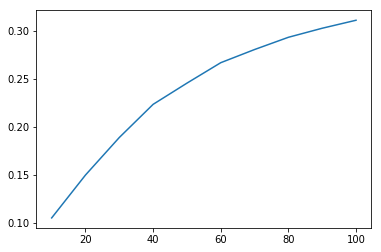

In [2]:
import matplotlib.pyplot as plt

plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
         [0.10499188404402464, 0.14970515053390282, 0.1888193396855732, 0.22338266958456865, 0.24548006683189091,
          0.26680334746718226, 0.2805234226981687, 0.2932795904934835, 0.3027138998653241, 0.3110476959302546])
plt.show()

### Evaluate Ranker On Each Fold
 
Based on the above analysis, there is a sharp increase in recall until you reach a depth of ~`80` at which point the increase in recall starts to level off (though ideally you might go higher to follow the trend).  So, for now, we choose `90` as the rows setting for our ranker as a compromise between the number of results which should be.  You can, of course, simply try a bunch of `rows` settings and evaluate overall ranker performance with each setting too.


**WARNING:** Each set of credentials gives you 8 rankers, since I experiment a lot, I have a convenience flag to delete rankers in case the quota is full. You obviously want to switch this flag off if you have rankers you don't want deleted.

In [6]:
rows=90
average_ndcg = 0.0
ndcg_evaluated_at = 50

for i in range(1, number_of_folds + 1):
    train_set = path.join(experimental_directory, 'Fold%d' % i, 'train.relevance_file.csv')     
    test_set = path.join(experimental_directory, 'Fold%d' % i, 'validation.relevance_file.csv')    
        
    # Step 1: Generate a feature file that can be used to train a ranker
    with smart_file_open(train_set) as infile:
        labelled_train_questions = RankerRelevanceFileQueryStream(infile)
        feature_file = insert_modifier_in_filename(train_set,'fcselect_features','txt')                
        with smart_file_open(feature_file, mode='w') as outfile:
            stats = generate_rnr_features(collection_id=collection_id, cluster_id=cluster_id, num_rows=rows,
                                      in_query_stream=labelled_train_questions, outfile=outfile, config=config)
        
    # Step 2: Train a ranker
    ranker_api_wrapper = RankerProxy(config=config)
    ranker_name = 'TestRanker'
    ranker_id = ranker_api_wrapper.train_ranker(train_file_location=feature_file, train_file_has_answer_id=True,
                                                is_enabled_make_space=True, ranker_name=ranker_name)
    ranker_api_wrapper.wait_for_training_to_complete(ranker_id=ranker_id)
        
    # Step 3: Generate predictions using the ranker id
    with smart_file_open(test_set) as infile:
        prediction_file = insert_modifier_in_filename(test_set,'fcselect_with_ranker_predictions','txt')
        labelled_test_questions = RankerRelevanceFileQueryStream(infile)
        json.dump(bluemix_wrapper.generate_fcselect_prediction_scores(
            test_questions=labelled_test_questions, num_rows=rows, ranker_id=ranker_id,
            prediction_file_location=prediction_file, collection_id=collection_id), sys.stdout, sort_keys=True, indent=4)
        
        # Step 4: Evaluate
        labelled_test_questions.reset()
        with smart_file_open(prediction_file) as preds_file:
            prediction_reader = PredictionReader(preds_file, file_has_confidence_scores=True)
            stats_for_fold, _ = compute_performance_stats(prediction_reader=prediction_reader,
                                                          ground_truth_query_stream=labelled_test_questions,
                                                          k=ndcg_evaluated_at)
            print('\nPerformance on Fold %d' % i)
            json.dump(stats_for_fold, sys.stdout, sort_keys=True, indent=4)
            average_ndcg += stats_for_fold['ndcg@%d' % ndcg_evaluated_at]

average_ndcg /= number_of_folds
print('\nAverage NDCG@%d across folds: %.2f' % (ndcg_evaluated_at, average_ndcg))


2017-05-17 23:36:06,638 INFO BluemixServiceProxy - Using previously created solr cluster id: sc40bbecbd_362a_4388_b61b_e3a90578d3b3
{
    "cluster_name": "Test Cluster",
    "cluster_size": "2",
    "solr_cluster_id": "sc40bbecbd_362a_4388_b61b_e3a90578d3b3",
    "solr_cluster_status": "READY"
}2017-05-17 23:36:50,277 INFO generate_rnr_feature_file.py - Processed 100 queries from input file
2017-05-17 23:37:33,393 INFO generate_rnr_feature_file.py - Processed 200 queries from input file
2017-05-17 23:38:16,656 INFO generate_rnr_feature_file.py - Processed 300 queries from input file
2017-05-17 23:39:00,123 INFO generate_rnr_feature_file.py - Processed 400 queries from input file
2017-05-17 23:39:43,634 INFO generate_rnr_feature_file.py - Processed 500 queries from input file
2017-05-17 23:40:26,780 INFO generate_rnr_feature_file.py - Processed 600 queries from input file
2017-05-17 23:41:10,007 INFO generate_rnr_feature_file.py - Processed 700 queries from input file
2017-05-17 23:41:5

{
    "cluster_name": "Test Cluster",
    "cluster_size": "2",
    "solr_cluster_id": "sc40bbecbd_362a_4388_b61b_e3a90578d3b3",
    "solr_cluster_status": "READY"
}2017-05-18 00:12:24,705 INFO generate_rnr_feature_file.py - Processed 100 queries from input file
2017-05-18 00:13:07,739 INFO generate_rnr_feature_file.py - Processed 200 queries from input file
2017-05-18 00:13:50,992 INFO generate_rnr_feature_file.py - Processed 300 queries from input file
2017-05-18 00:14:34,648 INFO generate_rnr_feature_file.py - Processed 400 queries from input file
2017-05-18 00:15:18,823 INFO generate_rnr_feature_file.py - Processed 500 queries from input file
2017-05-18 00:16:01,554 INFO generate_rnr_feature_file.py - Processed 600 queries from input file
2017-05-18 00:16:44,840 INFO generate_rnr_feature_file.py - Processed 700 queries from input file
2017-05-18 00:17:28,034 INFO generate_rnr_feature_file.py - Processed 800 queries from input file
2017-05-18 00:18:11,841 INFO generate_rnr_feature_fi

As we can see, both NDCG@20 and top-1 accuracy (aka Precision@1 goes up dramatically with the supervised ranker.  Refer here for troubleshooting tips with the ranker: https://developer.ibm.com/answers/questions/364292/solr-returns-the-ground-truth-relevant-results-but/